In [1]:
import torch as tc
tc.set_default_dtype(tc.float64)

In [2]:
import numpy as np
import dCl
from joblib import Parallel, delayed
import time

%load_ext autoreload
%autoreload 1
%aimport dCl

In [3]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 18,
})

In [4]:
Nz = 8
zmin = 0.3
zmax = 1.0
zmin_text = '{:.2f}'.format(zmin)
zmax_text = '{:.2f}'.format(zmax)
zlist = tc.linspace(zmin, zmax, Nz)
dCl_obj = dCl.Cl_kSZ2_HI2(zlist)

l_list = tc.linspace(30, 300, 19)
pz_list = 10.**tc.linspace(-3,-1, 16)

params = []
for l in l_list:
    for pz in pz_list:
        params.append([l, pz])

print('redshift from ' + zmin_text + ' to ' + zmax_text)
# params = tc.tensor(params).reshape([len(l_list)*len(pz_list), 2])

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


redshift from 0.30 to 1.00


### 1. Run the code to get dCl data

#### dCl : $\mathrm{kSZ}^2 \times \mathrm{HI}^2$

In [ ]:
def generate_l1_list():
    return tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

def generate_lmax(l1, pz_chi):
    lmax = 2. * (l1 + pz_chi)
    lmax_cut = tc.ones_like(l1) * 150.
    return tc.max(lmax, lmax_cut)

def generate_Ntheta(l1, pz_chi):
    return 300 + 3 * tc.tensor(l1 /50 / pz_chi**(0.1), dtype=tc.int32)
    

def compute(zindex, l, pz, l1, lmax, Ntheta):
    res_beam, res_nobeam = dCl_obj.dCl_lm_Term5(zindex, l, l1, pz, l_max=lmax, N_theta=Ntheta, beam='both')
    # res6 = dCl_obj.dCl_lp_Term6(zindex, l, l1, pz, l_max=lmax, N_theta=Ntheta)
    return res_beam, res_nobeam


In [ ]:
N_JOBS = 4
l1_list = generate_l1_list()
length_p = len(params)
length100 = length_p * Nz / 100


time0 = time.time()
for zindex in range(len(zlist)):
    res_beam = []
    res_nobeam = []
    for i, p in enumerate(params):
        l, pz = p
        chi = dCl_obj.chi_of_z[zindex]    
        lmax = generate_lmax(l1_list, pz*chi)
        Ntheta = generate_Ntheta(l1_list, pz*chi)

        res_p = Parallel(n_jobs=N_JOBS, prefer='threads')(delayed(compute)(zindex, l, pz, l1_list[l1_index], lmax[l1_index], Ntheta[l1_index]) 
                                                        for l1_index in range(len(l1_list)))
        
        res_beam_p = [r[0] for r in res_p]
        res_nobeam_p = [r[1] for r in res_p]

        res_beam.append(res_beam_p)
        res_nobeam.append(res_nobeam_p)

        time_i = time.time() - time0
        total_index = zindex * length_p + i
        print(total_index, 'percent: {:.3f}%'.format((total_index+1)/length100), 
            ', average velocity: {:.4f}% per min'.format((total_index+1)/length100 * 60. / time_i), 
            '    ', end='\r')
    
    res_beam_w = tc.tensor(res_beam).reshape([len(l_list), len(pz_list), len(l1_list)])
    res_nobeam_w = tc.tensor(res_nobeam).reshape([len(l_list), len(pz_list), len(l1_list)])

    np.save('Beam_data/z_' + zmin_text + '_' + zmax_text + f'/Cl_cross_{zindex}.npy', res_beam_w)
    np.save(f'NoBeam_data/z_' + zmin_text + '_' + zmax_text + f'/Cl_cross_{zindex}.npy', res_nobeam_w)

        

#### dCl :  $\mathrm{HI}$ auto-correlation and $\mathrm{HI}^2$ auto-correlation

In [5]:
res_beam = tc.empty([Nz, len(l_list)])
res_nobeam = tc.empty([Nz, len(l_list)])

for zi in range(Nz):
    for li in range(len(l_list)):
        res_nobeam[zi, li], res_beam[zi, li] = dCl_obj.dCl_HI2(zi=zi, l=l_list[li], beam='both')

res_beam.shape

torch.Size([8, 19])

In [6]:
np.save('Beam_data/z_' + zmin_text + '_' + zmax_text + '/dCl_HI2.npy', res_beam)
np.save('NoBeam_data/z_' + zmin_text + '_' + zmax_text + '/dCl_HI2.npy', res_nobeam)

#### dCl :  $\mathrm{kSZ}$ auto-correlation and $\mathrm{kSZ}^2$ auto-correlation

In [5]:
zmax, Nzksz = 12, 100
kSZ_obj = dCl.Cl_kSZ2(zmax=zmax, zmin=0.001, Nz=Nzksz, nonlinear=True)

Note: redshifts have been re-sorted (earliest first)


In [6]:
l_list = tc.tensor(np.geomspace(10, 1e5, 101))

Cl_kSZ = tc.empty_like(l_list)

for i, l in enumerate(l_list):
    Cl_kSZ[i] = kSZ_obj.Cl_kSZ(l, beam=True)
    print(i, l, '   ', end='\r')

Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list)

np.save('Data/Cl_kSZ.npy', Cl_kSZ)
np.save('Data/Cl_kSZ_nobeam.npy', Cl_kSZ_nobeam)

In [7]:
Cl_kSZ = tc.tensor(np.load('Data/Cl_kSZ.npy'))
CL_kSZ2 = kSZ_obj.Cl_kSZ2(l_list=l_list, Cl_kSZ=Cl_kSZ)
np.save('Data/CL_kSZ2.npy', np.array(CL_kSZ2))

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-udngs7fm/pytorch_1648016055234/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Figure size 500x309 with 0 Axes>

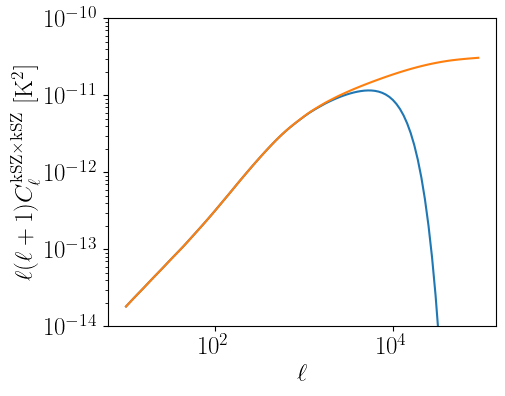

In [8]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

# times (2.7K)^2 to convert to temperature unit
fig = plt.figure(figsize=(5,4))
xi, xe = 0, -1
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ)[xi:xe] * (2.7)**2, '-', label='with beam')
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ_nobeam)[xi:xe] * (2.7)**2, '-', label='no beam')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-10])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}}$ [$\mathrm{K}^2$]', usetex=True)

# plt.savefig('Cl_HI2.pdf', bbox_inches = 'tight')
plt.show()

In [9]:
zmax, Nzksz = 12, 100
kSZ_obj = dCl.Cl_kSZ2(zmax=zmax, zmin=0.001, Nz=Nzksz, nonlinear=False)

Note: redshifts have been re-sorted (earliest first)


In [10]:
l_list = tc.tensor(np.geomspace(10, 1e5, 101))

Cl_kSZ = tc.empty_like(l_list)

for i, l in enumerate(l_list):
    Cl_kSZ[i] = kSZ_obj.Cl_kSZ(l, beam=True)
    print(i, l, '   ', end='\r')

Cl_kSZ_nobeam = Cl_kSZ / kSZ_obj.Beam_kSZ(l_list)

np.save('Data/Cl_kSZ_linear.npy', Cl_kSZ)
np.save('Data/Cl_kSZ_nobeam_linear.npy', Cl_kSZ_nobeam)

In [11]:
Cl_kSZ = tc.tensor(np.load('Data/Cl_kSZ_linear.npy'))
CL_kSZ2 = kSZ_obj.Cl_kSZ2(l_list=l_list, Cl_kSZ=Cl_kSZ)
np.save('Data/CL_kSZ2_linear.npy', np.array(CL_kSZ2))

<Figure size 500x309 with 0 Axes>

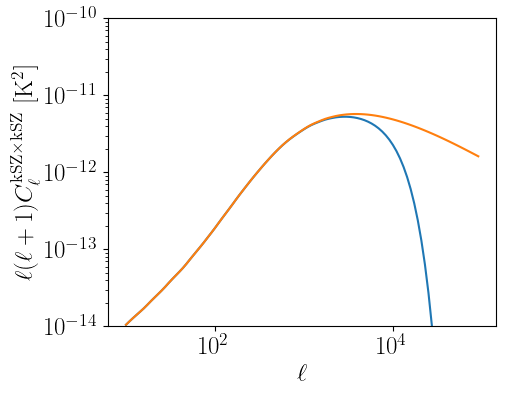

In [12]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

# times (2.7K)^2 to convert to temperature unit
fig = plt.figure(figsize=(5,4))
xi, xe = 0, -1
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ)[xi:xe] * (2.7)**2, '-', label='with beam')
plt.plot(l_list[xi:xe], (l_list * (l_list + 1) * Cl_kSZ_nobeam)[xi:xe] * (2.7)**2, '-', label='no beam')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-10])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}}$ [$\mathrm{K}^2$]', usetex=True)

# plt.savefig('Cl_HI2.pdf', bbox_inches = 'tight')
plt.show()

### 2. Read in the data

#### Test on Term 5 and 6 Cross-correlation

In [24]:
Nz = 2
zlist = tc.linspace(0.4, 0.5, Nz)
l_list = tc.linspace(50, 200, 10)
pz_list = 10.**tc.linspace(-3,-1, 16)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor (2pi)^(-5) for volume element from integral over l1 l2 pz
data_total = tc.tensor(np.load('Data/Term5and6.npy')) * 2 * 2 / (2*tc.pi)**5

print(len(zlist), len(l_list), len(pz_list), len(l1_list), data_total.shape[-1])
print(data_total.shape)

2 10 16 90 2
torch.Size([2, 10, 16, 90, 2])


In [25]:
########################################################################
# Sum over term 5 and 6, and then integrate over l1
data_term5 = tc.trapz(data_total[..., 0], l1_list, dim=-1)
data_term6 = tc.trapz(data_total[..., 1], l1_list, dim=-1)
data_int_l1 = tc.trapz(data_total.sum(dim=-1), l1_list, dim=-1)

########################################################################
# Integrate over pz
data_int_pz = tc.trapz(data_int_l1, pz_list, dim=-1)

########################################################################
# Integrate over chi
dCl_obj = dCl.Cl_kSZ2_HI2(np.array([0.4, 0.5]))
Cl_cross = tc.trapz(data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI , dCl_obj.chi_of_z, dim=-1)

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


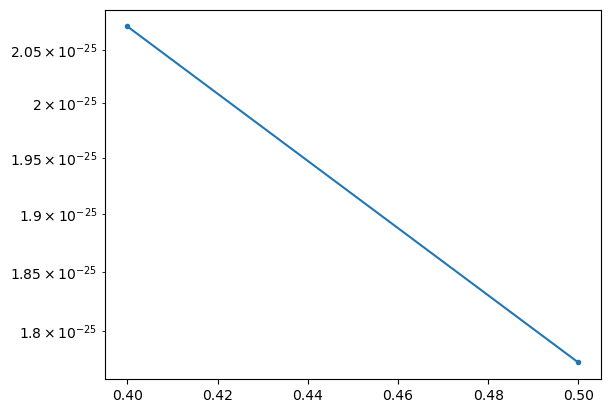

In [19]:
plt.plot(dCl_obj.z_list, (data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI)[0], '.-')
plt.yscale('log')
plt.show()

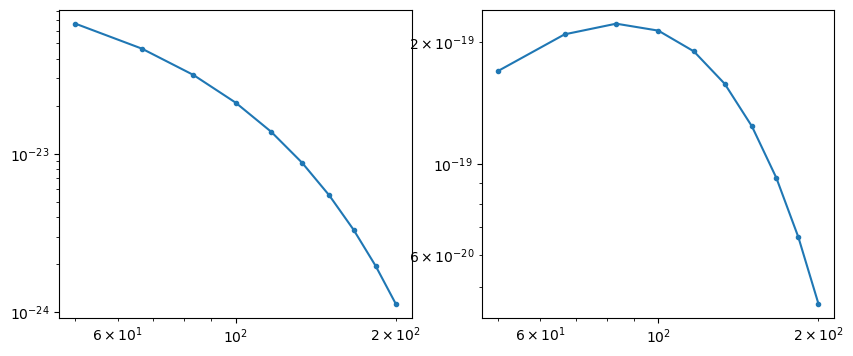

In [27]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
dCl_obj.F_kSZ, dCl_obj.G_HI

(tensor([4.5763e-13, 3.5487e-13]), tensor([4.7843e-13, 4.0132e-13]))

#### Cross-correlation

In [9]:
Nz = 8
zmin = 0.3
zmax = 1.0
zlist = tc.linspace(zmin, zmax, Nz)
l_list = tc.linspace(30, 300, 19)
pz_list = 10.**tc.linspace(-3,-1, 16)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                    10.**tc.linspace(0, 1, 6)[:-1], 
                    tc.linspace(10, 300, 59)[:-1], 
                    10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                    10.**tc.linspace(3, 4, 10)])

# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor (2pi)^(-5) for volume element from integral over l1 l2 pz
# data_total = tc.tensor(np.load('Data/Term5and6.npy')) * 2 * 2 / (2*tc.pi)**5

data_total = []
for i in range(8):
    data_i = np.load(f'./Beam_data/z_0.30_1.00/Cl_cross_{i}.npy') / 1e6 # convert to K^2
    data_total.append(data_i)

data_total = np.array(data_total)
data_total = tc.tensor(data_total) * 2 * 2 / (2*tc.pi)**5


print(len(zlist), len(l_list), len(pz_list), len(l1_list), data_total.shape[-1])
print(data_total.shape)

8 19 16 90 90
torch.Size([8, 19, 16, 90])


In [10]:
########################################################################
# Integrate over l1
data_int_l1 = tc.trapz(2 * data_total, l1_list, dim=-1)

########################################################################
# Integrate over pz
data_int_pz = tc.trapz(data_int_l1, pz_list, dim=-1)

########################################################################
# Integrate over chi
Cl_cross = tc.trapz(data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI , dCl_obj.chi_of_z, dim=-1)

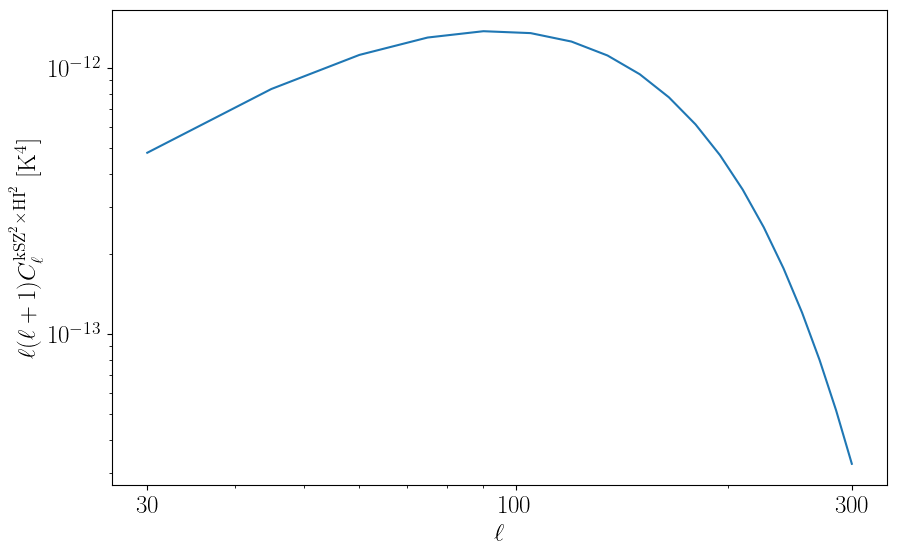

In [11]:
fig = plt.figure(figsize=(10, 6.18), dpi=100)

# times (2.7K)^2 to convert to temperature unit
plt.plot(l_list, l_list * (l_list + 1) * Cl_cross * (2.7)**2, '-')
plt.xscale('log')
plt.yscale('log')

plt.xticks([30, 100, 300], ['30', '100', '300'])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2}$ [$\mathrm{K}^4$]', usetex=True)

# plt.savefig('cross_correlation.pdf', bbox_inches = 'tight')
plt.show()

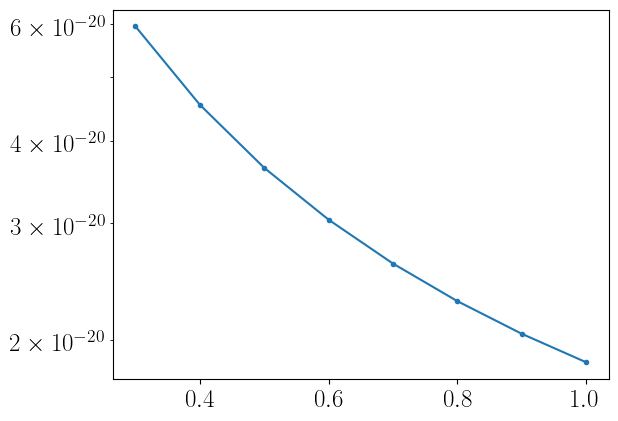

In [30]:
plt.plot(dCl_obj.z_list, (data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI)[0], '.-')
plt.yscale('log')
plt.show()

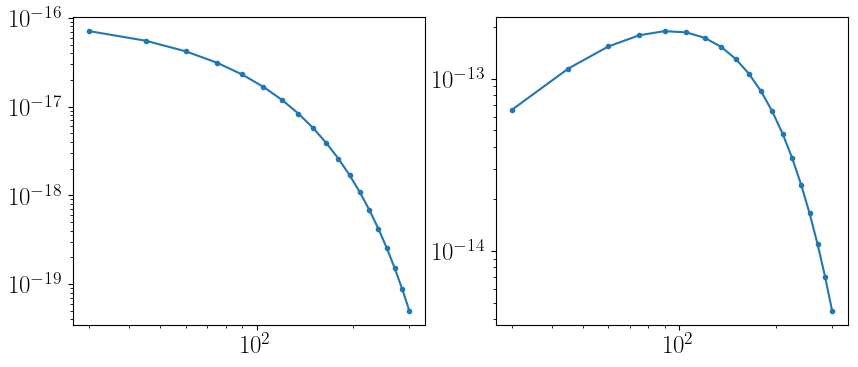

In [31]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### HI square field auto-correlation

In [6]:
Nz = 8
zmin = 0.3
zmax = 1.0
zlist = tc.linspace(zmin, zmax, Nz)
l_list = tc.linspace(30, 300, 19)

dCl_HI2 = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2.npy'))
dCl_HI2_nobeam = tc.tensor(np.load('NoBeam_data/z_0.30_1.00/dCl_HI2.npy'))


# Integrate over chi
Cl_HI2 = tc.trapz(dCl_HI2.T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)
Cl_HI2_nobeam = tc.trapz(dCl_HI2_nobeam.T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)

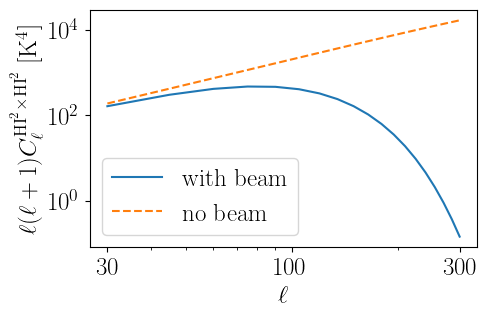

In [7]:
fig = plt.figure(figsize=(5, 3.09), dpi=100)

# times (2.7K)^2 to convert to temperature unit
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2, '-', label='with beam')
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2_nobeam, '--', label='no beam')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xticks([30, 100, 300], ['30', '100', '300'])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2}$ [$\mathrm{K}^4$]', usetex=True)

plt.savefig('Cl_HI2.pdf', bbox_inches = 'tight')
plt.show()

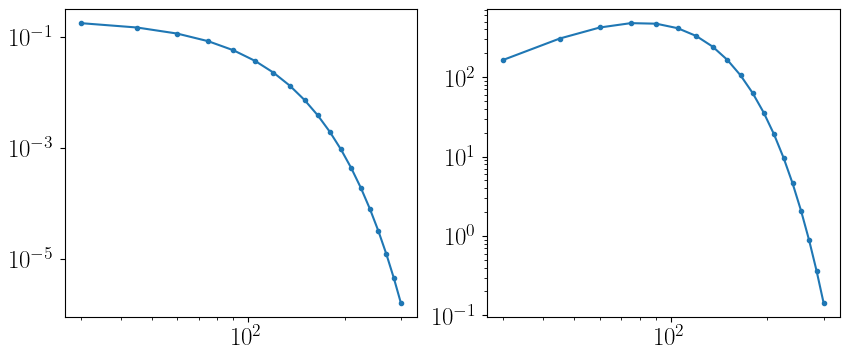

In [14]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_HI2, '.-')
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2, '.-')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### kSZ square field auto-correlation

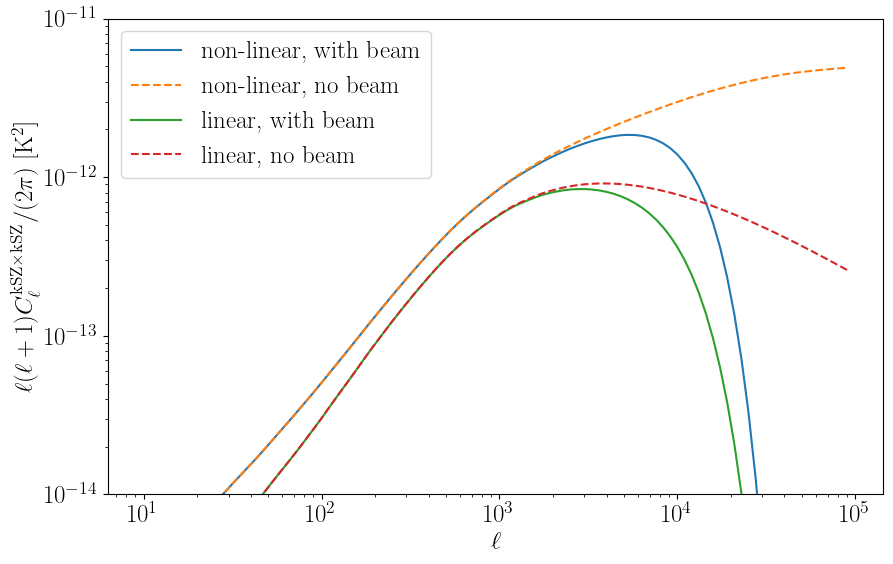

In [5]:
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))

# times (2.7K)^2 to convert to temperature unit
Cl_kSZ = tc.tensor(np.load('Data/Cl_kSZ.npy')) * (2.7)**2 / (2*np.pi)
Cl_kSZ_nobeam = Cl_kSZ / dCl_obj.Beam_kSZ(l_list_kSZ)

Cl_kSZ_linear = tc.tensor(np.load('Data/Cl_kSZ_linear.npy'))* (2.7)**2 / (2*np.pi)
Cl_kSZ_nobeam_linear = Cl_kSZ_linear / dCl_obj.Beam_kSZ(l_list_kSZ)


fig = plt.figure(figsize=(10, 6.18), dpi=100)

xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ)[xi:xe], '-', label='non-linear, with beam')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam)[xi:xe], '--', label='non-linear, no beam')

plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_linear)[xi:xe], '-', label='linear, with beam')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ_nobeam_linear)[xi:xe], '--', label='linear, no beam')

plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-11])

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ} \times {\rm kSZ}} / (2\pi)$ [$\mathrm{K}^2$]', usetex=True)

plt.savefig('Cl_kSZ.pdf', bbox_inches = 'tight')
plt.show()

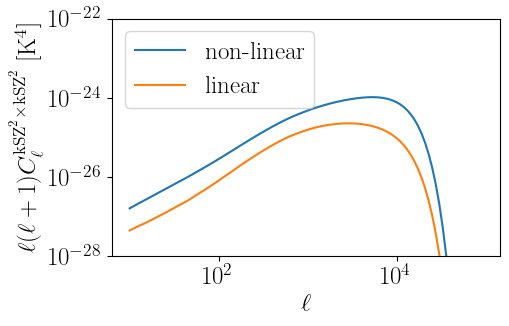

In [33]:
# The factor (2pi)^(-2) for volume element from convolution over l'
CL_kSZ2 = tc.tensor(np.load('Data/CL_kSZ2.npy')) / (2*tc.pi)**2
CL_kSZ2_linear = tc.tensor(np.load('Data/CL_kSZ2_linear.npy')) / (2*tc.pi)**2

fig = plt.figure(figsize=(5, 3.09), dpi=100)
xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * CL_kSZ2)[xi:xe], '-', label='non-linear')
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * CL_kSZ2_linear)[xi:xe], '-', label='linear')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$ [$\mathrm{K}^4$]', usetex=True)
plt.ylim([1e-28, 1e-22])

plt.savefig('Cl_kSZ2.pdf', bbox_inches = 'tight')
plt.show()

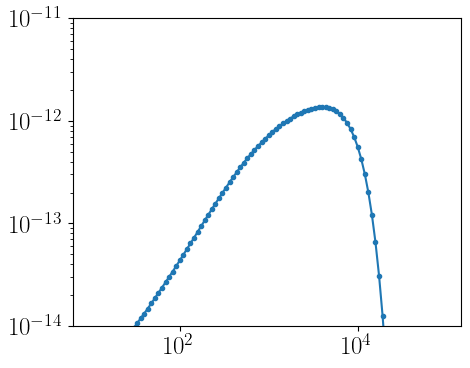

In [20]:
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))

Cl_kSZ = tc.tensor(np.load('Data/Cl_kSZ.npy'))

fig = plt.figure(figsize=(5,4))
xi, xe = 0, -1
plt.plot(l_list_kSZ[xi:xe], (l_list_kSZ * (l_list_kSZ + 1) * Cl_kSZ)[xi:xe], '.-')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-14, 1e-11])
plt.show()

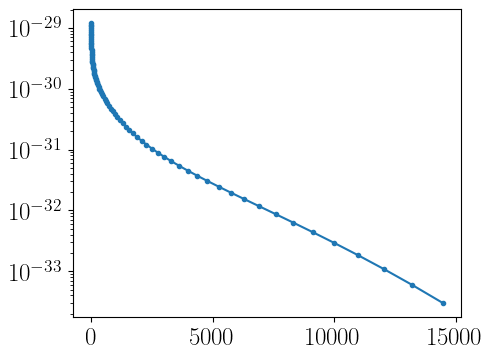

In [21]:
# The factor (2pi)^(-2) for volume element from convolution over l'
CL_kSZ2 = tc.tensor(np.load('Data/CL_kSZ2.npy')) / (2*tc.pi)**2

fig = plt.figure(figsize=(5,4))
xi, xe = 0, 80
plt.plot(l_list_kSZ[xi:xe], CL_kSZ2[xi:xe], '.-')
plt.yscale('log')
plt.show()

#### SNR estimation

In [8]:
def get_Cl_cross(dCl_cross, dCl_obj, pz_list, l1_list):
    ########################################################################
    # Integrate over l1
    data_int_l1 = tc.trapz(2 * dCl_cross, l1_list, dim=-1)

    ########################################################################
    # Integrate over pz
    data_int_pz = tc.trapz(data_int_l1, pz_list, dim=-1)

    ########################################################################
    # Integrate over chi
    Cl_cross = tc.trapz(data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI , dCl_obj.chi_of_z, dim=-1)

    return Cl_cross


def torch_interp1d(x, y, x_new):

    indices = tc.searchsorted(x, x_new) - 1
    indices = tc.clamp(indices, 0, len(x) - 2)

    x0, x1 = x[indices], x[indices + 1]
    y0, y1 = y[indices], y[indices + 1]

    slope = (y1 - y0) / (x1 - x0)
    y_query = y0 + slope * (x_new - x0)
    
    return y_query

def loglog_torch_itp(x, y, x_new):
    return 10**torch_interp1d(tc.log10(x), tc.log10(y), tc.log10(x_new))

In [14]:
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                    10.**tc.linspace(0, 1, 6)[:-1], 
                    tc.linspace(10, 300, 59)[:-1], 
                    10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                    10.**tc.linspace(3, 4, 10)])

''' 1. Get Cl_cross'''
# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor (2pi)^(-5) for volume element from integral over l1 l2 pz
data_total = []
for i in range(8):
    data_i = np.load(f'./Beam_data/z_0.30_1.00/Cl_cross_{i}.npy') / 1e6  # convert to K^2
    data_total.append(data_i)

data_total = np.array(data_total)
data_total = tc.tensor(data_total) * 2 * 2 / (2*tc.pi)**5
Cl_cross = get_Cl_cross(data_total, dCl_obj, pz_list, l1_list)

''' 2. Get Cl_HI square'''
dCl_HI2 = tc.tensor(np.load('Beam_data/z_0.30_1.00/dCl_HI2.npy'))
Cl_HI2 = tc.trapz(dCl_HI2.T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)

''' 3. Get Cl_kSZ square'''
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
CL_kSZ2 = tc.tensor(np.load('Data/CL_kSZ2.npy')) / (2*tc.pi)**2


''' 4. Evaluate SNR square'''
l_list = tc.linspace(30, 300, 19)
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
l30_300 = tc.arange(30, 300)

Cl_kSZ2_HI2  = loglog_torch_itp(l_list, Cl_cross, l30_300)
Cl_HI2_auto  = loglog_torch_itp(l_list, Cl_HI2, l30_300)
Cl_kSZ2_auto = loglog_torch_itp(l_list_kSZ, CL_kSZ2, l30_300)

fsky = 1/10.
SNR = fsky * (2 * l30_300 + 1) * Cl_kSZ2_HI2**2 / (Cl_kSZ2_HI2**2 + Cl_HI2_auto * Cl_kSZ2_auto)
SNR_cs = tc.cumsum(SNR,dim=0)

SNR.shape, SNR_cs.shape

(torch.Size([270]), torch.Size([270]))

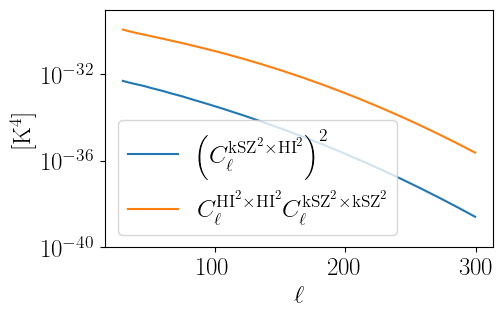

In [20]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(l30_300, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_300, Cl_HI2_auto * Cl_kSZ2_auto, label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-40, 1e-29])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)

plt.savefig('Figs/comparison.pdf', bbox_inches = 'tight')
plt.show()

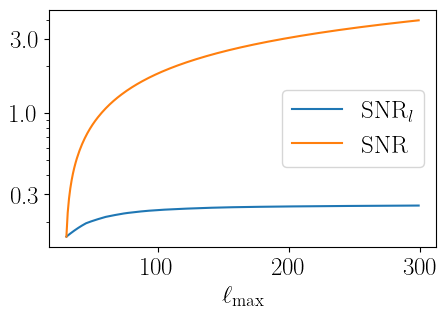

In [21]:
fig = plt.figure(figsize=(5,3.09), dpi=100)

plt.plot(l30_300, np.sqrt(SNR), label = r'$\mathrm{SNR}_l$')
plt.plot(l30_300, np.sqrt(SNR_cs), label = r'$\mathrm{SNR}$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.yticks([0.3,1,3], [0.3,1.0,3.0])

plt.xlabel(r'$\ell_{\mathrm{max}}$', usetex=True)

plt.savefig('Figs/SNR.pdf', bbox_inches = 'tight')
plt.show()

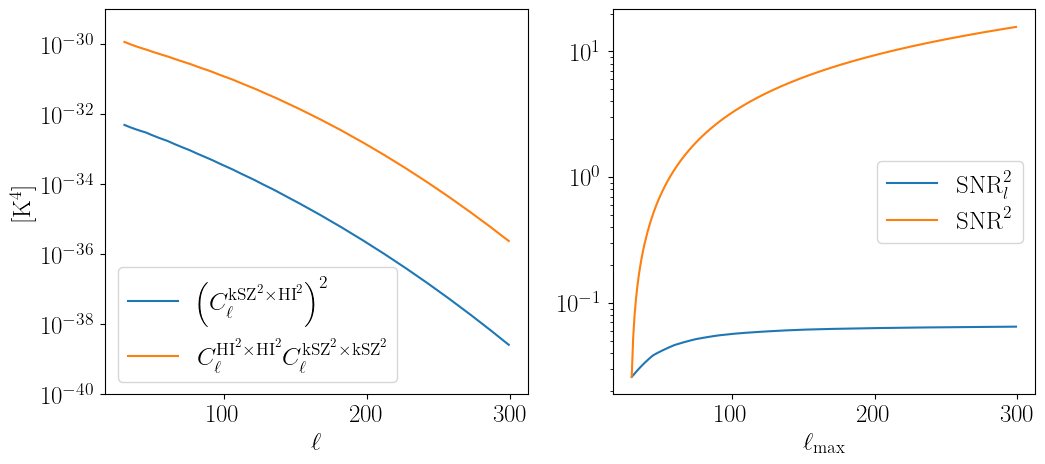

In [42]:
# With all beams
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(l30_300, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_300, Cl_HI2_auto * Cl_kSZ2_auto, label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-40, 1e-29])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)


plt.subplot(1,2,2)
plt.plot(l30_300, SNR, label = r'$\mathrm{SNR}_l^2$')
plt.plot(l30_300, SNR_cs, label = r'$\mathrm{SNR}^2$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell_{\mathrm{max}}$', usetex=True)

# plt.savefig('Figs/SNR2.pdf', bbox_inches = 'tight')
plt.show()

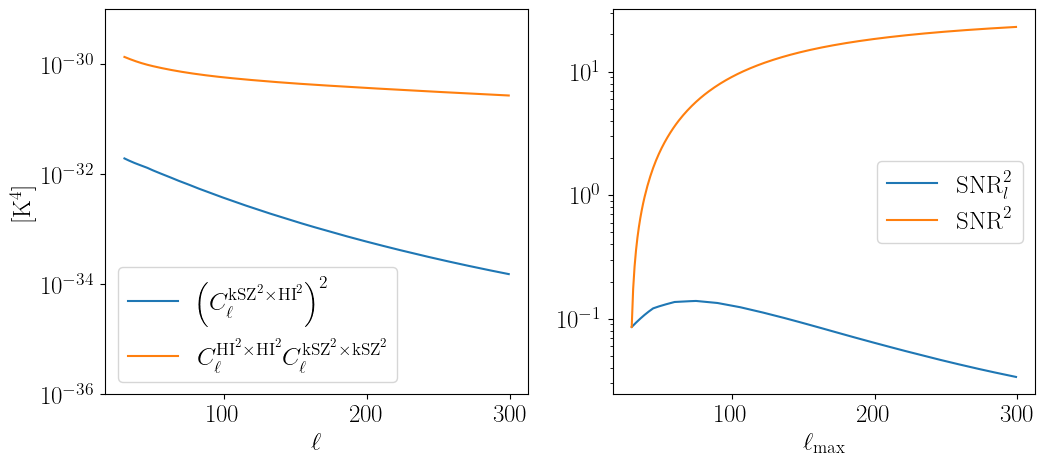

In [45]:
# Remove HI beams
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(l30_300, Cl_kSZ2_HI2**2, label = r'$\left( C_{\ell}^{{\rm kSZ}^2 \times {\rm HI}^2} \right)^2$')
plt.plot(l30_300, Cl_HI2_auto * Cl_kSZ2_auto, label = r'$C_{\ell}^{{\rm HI}^2 \times {\rm HI}^2} C_{\ell}^{{\rm kSZ}^2 \times {\rm kSZ}^2}$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-36, 1e-29])
plt.xlabel(r'$\ell$', usetex=True)
plt.ylabel(r'[$\mathrm{K}^4$]', usetex=True)


plt.subplot(1,2,2)
plt.plot(l30_300, SNR, label = r'$\mathrm{SNR}_l^2$')
plt.plot(l30_300, SNR_cs, label = r'$\mathrm{SNR}^2$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell_{\mathrm{max}}$', usetex=True)

plt.savefig('Figs/SNR2_nobeam.pdf', bbox_inches = 'tight')
plt.show()

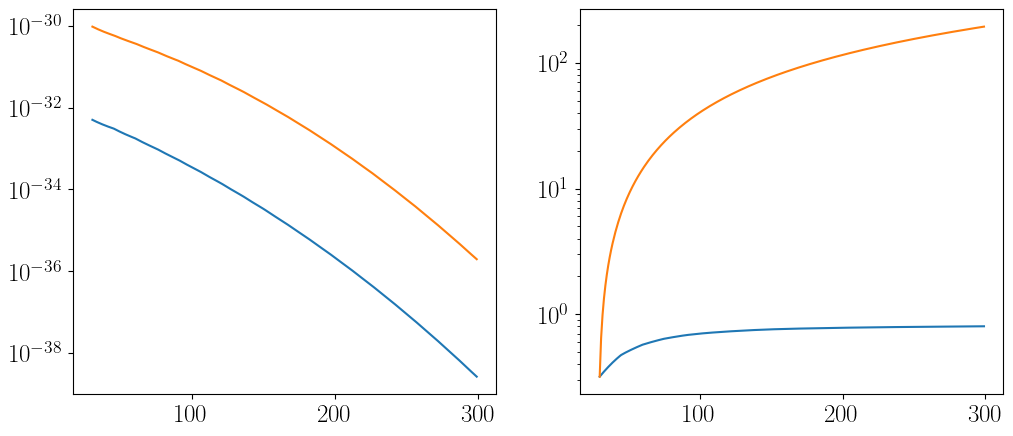

In [24]:
# With all beams
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(l30_300, Cl_kSZ2_HI2**2)
plt.plot(l30_300, Cl_HI2_auto * Cl_kSZ2_auto)
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l30_300, SNR)
plt.plot(l30_300, SNR_cs)
plt.yscale('log')

plt.show()

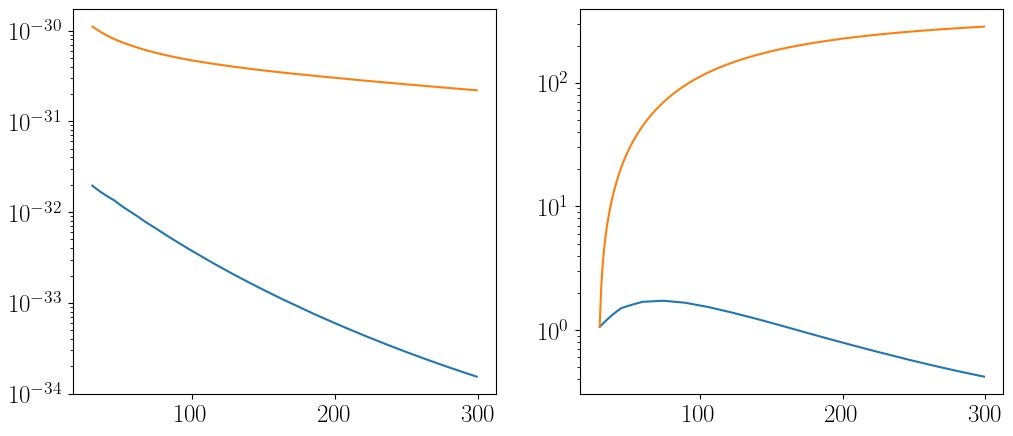

In [27]:
# No beam result
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(l30_300, Cl_kSZ2_HI2**2)
plt.plot(l30_300, Cl_HI2_auto * Cl_kSZ2_auto)
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l30_300, SNR)
plt.plot(l30_300, SNR_cs)
plt.yscale('log')


plt.show()

### Other Plots

#### Cross-correlation

In [57]:
data6 = np.load('./Beam_data/z_0.30_1.00/Cl_cross_6.npy')
data7 = np.load('./Beam_data/z_0.30_1.00/Cl_cross_7.npy')
data_total = tc.tensor(np.array([data6, data7])) * 2 * 2 / (2*tc.pi)**5

l_list = tc.linspace(30, 300, 19)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

data_total.shape

torch.Size([2, 19, 16, 90])

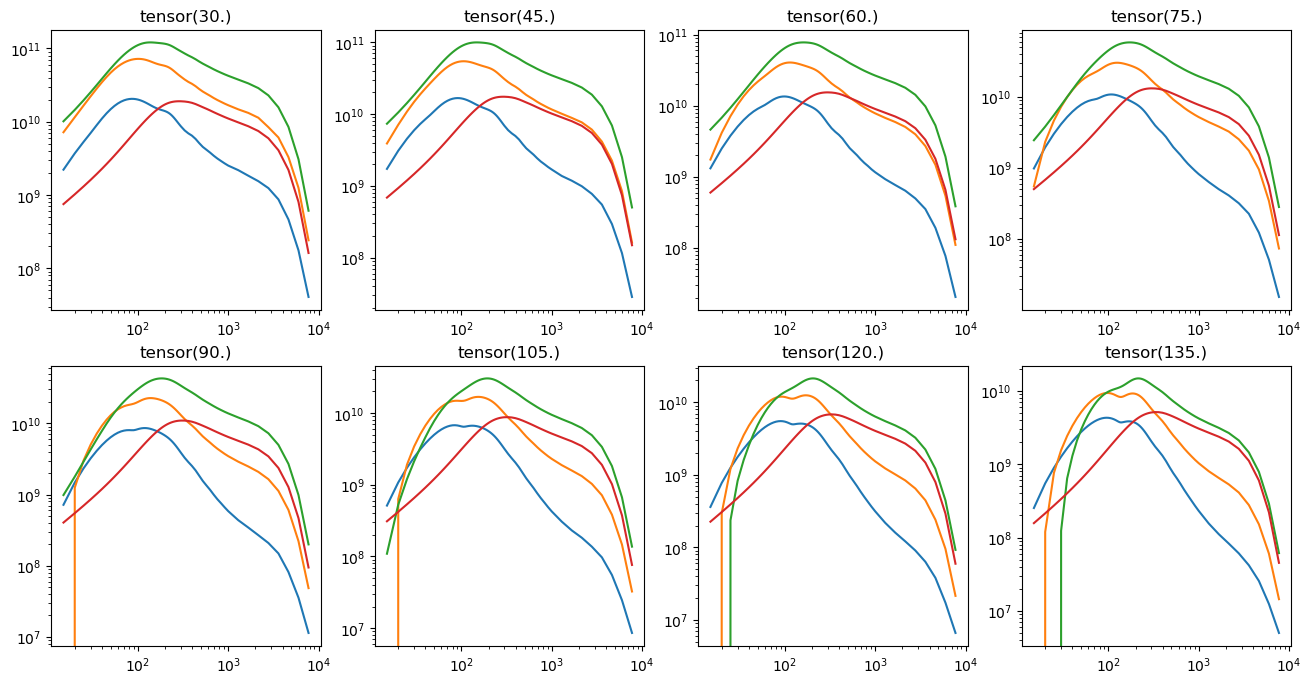

In [58]:
data_beam = data_total[0]

lindex = 3 # l=100
pz_index = 0 # pz=0.01
temr_index = 0
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))

xi, xe = 10, -1

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe].T)
    # plt.plot(l1_list[xi:xe], data_beam[i, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe].T)
    # plt.plot(l1_list[xi:xe], data_beam[i+4, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i+4]))

plt.show()

In [59]:
data_term_both = tc.trapz(data_total, l1_list, dim=-1)

data_term_both.shape

torch.Size([2, 19, 16])

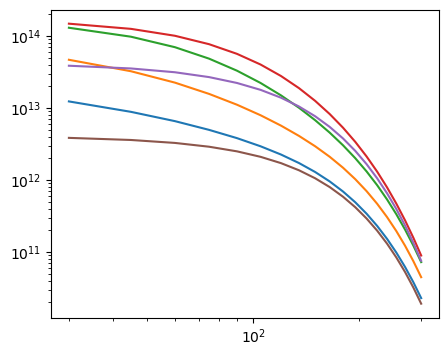

In [61]:
zindex = 0
pz_index = 1
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(5,4))

plt.plot(l_list, data_term_both[zindex, :, ::3])
plt.xscale(xscale)
plt.yscale(yscale)

plt.show()


In [62]:
pz_list.shape, data_term_both.shape

(torch.Size([16]), torch.Size([2, 19, 16]))

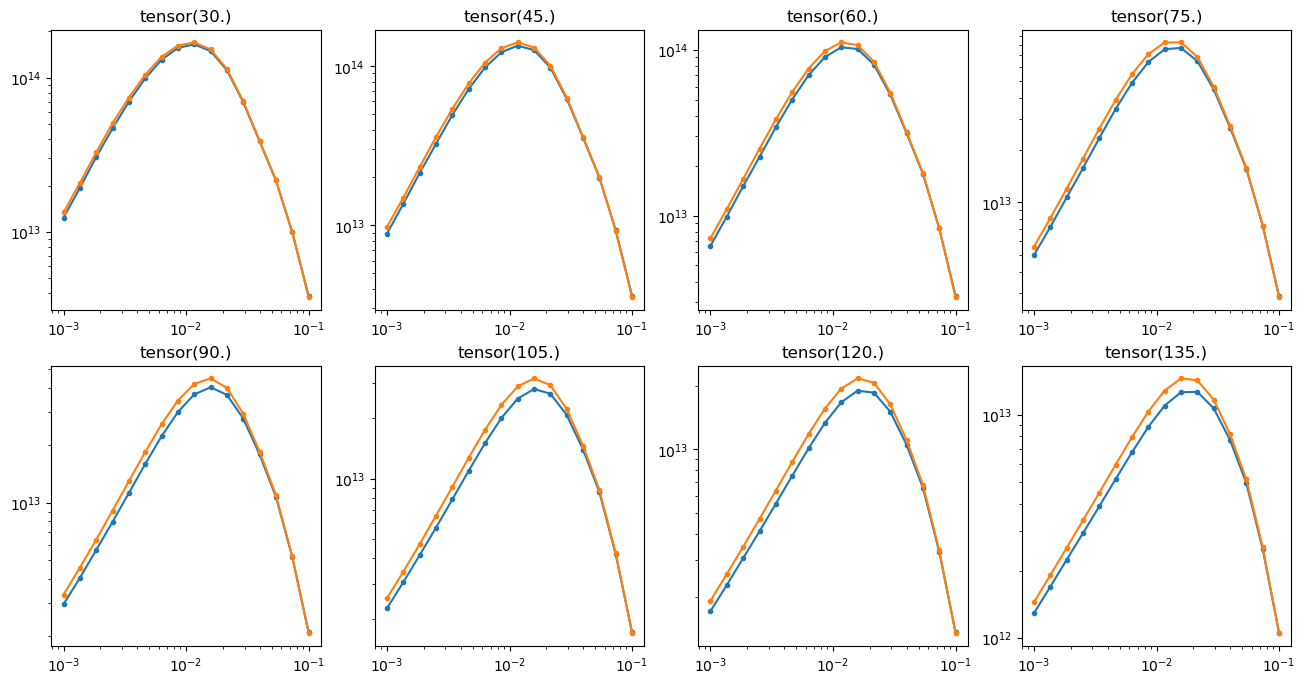

In [63]:
lindex = 0 # l=50
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))


for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(pz_list, data_term_both[:, i].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(pz_list, data_term_both[:, i+5].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i+4]))

plt.show()

#### Test on Term 5 and 6 Cross-correlation

In [33]:
data_total = tc.tensor(np.load('Data/Term5and6.npy')) * 2 * 2 / (2*tc.pi)**5

l_list = tc.linspace(50, 200, 10)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

data_total.shape

torch.Size([2, 10, 16, 90, 2])

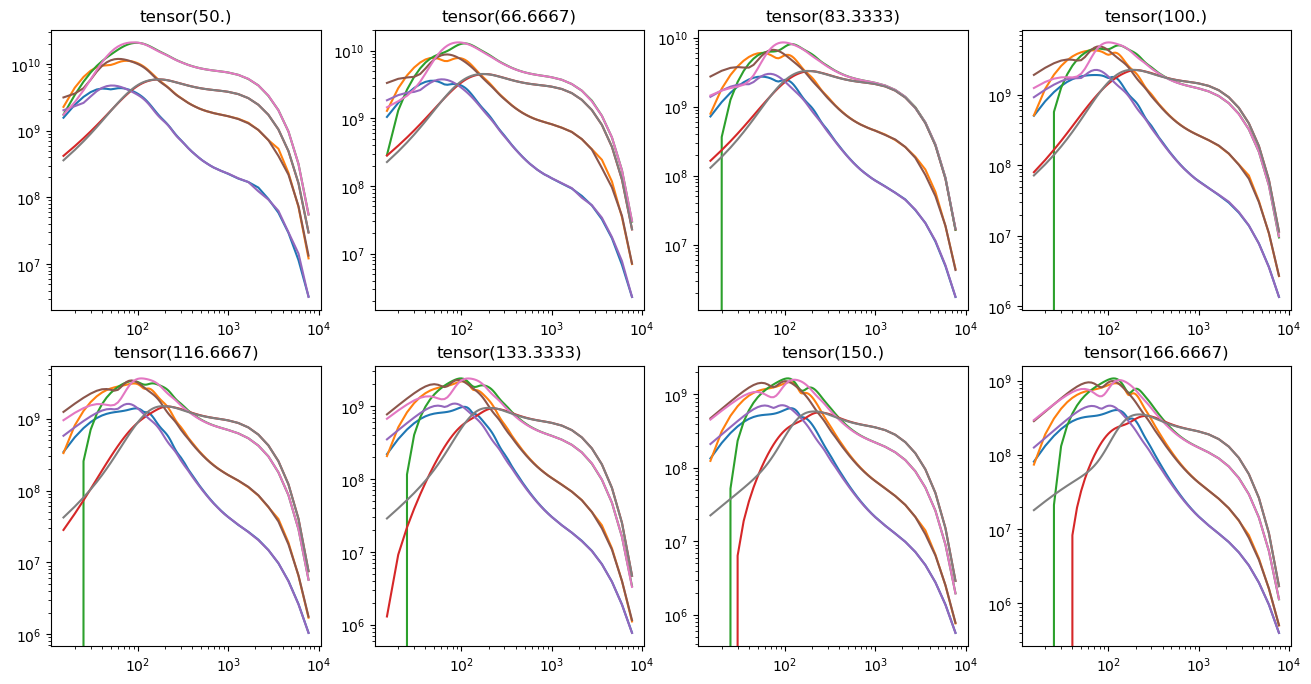

In [34]:
data_beam = data_total[0]

lindex = 3 # l=100
pz_index = 0 # pz=0.01
temr_index = 0
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))

xi, xe = 10, -1

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe, 0].T)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe, 1].T)
    # plt.plot(l1_list[xi:xe], data_beam[i, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe,0].T)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe, 1].T)
    # plt.plot(l1_list[xi:xe], data_beam[i+4, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i+4]))

plt.show()

In [37]:
data_term5 = tc.trapz(data_total[..., 0], l1_list, dim=-1)
data_term6 = tc.trapz(data_total[..., 1], l1_list, dim=-1)
data_term_both = tc.trapz(data_total.sum(dim=-1), l1_list, dim=-1)

data_term5.shape, data_term_both.shape

(torch.Size([2, 10, 16]), torch.Size([2, 10, 16]))

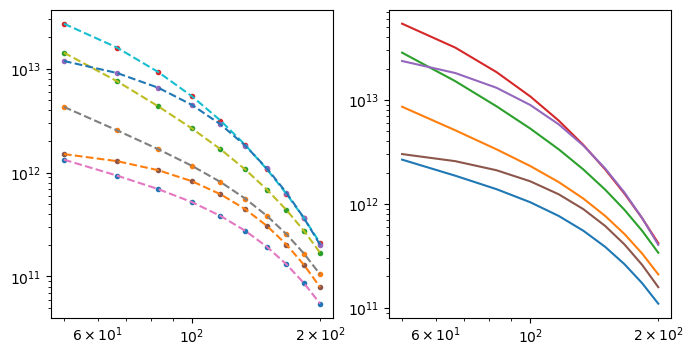

In [38]:
zindex = 0 # z=0.4
pz_index = 1 # pz=0.01
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(l_list, data_term5[zindex,:, ::3], '.')
plt.plot(l_list, data_term6[zindex,:, ::3], '--')
plt.xscale(xscale)
plt.yscale(yscale)

plt.subplot(1,2,2)
plt.plot(l_list, data_term_both[zindex,:, ::3])
plt.xscale(xscale)
plt.yscale(yscale)

plt.show()


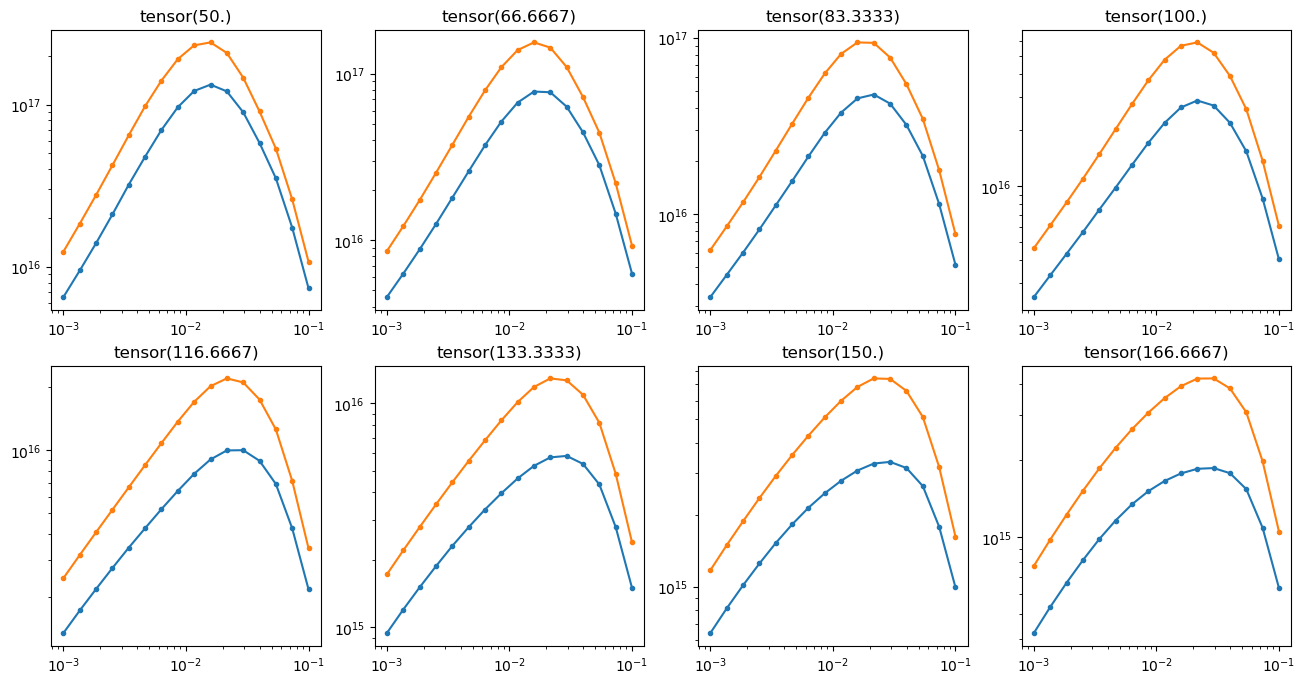

In [24]:
lindex = 0 # l=50
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))


for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(pz_list, data_term_both[:, i].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(pz_list, data_term_both[:, i+5].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i+4]))

plt.show()